In [55]:
import pathlib
import datetime

import pint
import dateutil.parser
import numpy as np
import pandas as pd

import scipy.interpolate

import matplotlib.pyplot as plt

ureg = pint.UnitRegistry()

%matplotlib inline

0.055833333334736834

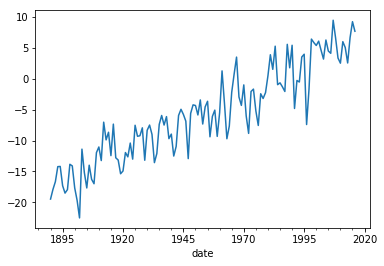

In [83]:
mean_sl_path = pathlib.Path('~/src/sealevel-svn/editorial/2018/mean_sl_plot.csv').expanduser()

slr_df = pd.read_csv(mean_sl_path)
slr_df['date'] = slr_df['year'].apply(lambda x:dateutil.parser.parse(x))
slr_df = slr_df.set_index('date')
# convert to units
height_mm = slr_df['height'].values * ureg.centimeter
height_m = height_mm.to(ureg.meter)
slr_df['height_m'] = height_m
slr_df['height'].plot()


def mean_sl_between_years(df, a, b):
    """return the mean waterlevel in m for a <= period < b"""
    index = np.logical_and(
        df.index >= datetime.datetime(a, 1, 1),
        df.index < datetime.datetime(b, 1, 1)
    )
    waterlevel = df[index].mean(axis=0)['height_m']
    return waterlevel
mean_sl_between_years(slr_df, 2016, 2017) - mean_sl_between_years(slr_df, 1986, 2005)


In [34]:
# IPCC 2013 AR5 - reference year 1986-2005 (1995.5, plotted on 1995)
# Table 13.5 in Chapter 13
records = []

meta = {
    "organization": "IPCC",
    "name": "AR5",
    # scenario started in this period
    "correction": lambda x: x + mean_sl_between_years(slr_df, 1986, 2005),
    "years": np.array([1995, 2055, 2100])
}
record = {**meta}
record["scenario"] = "A1B"
record['min'] = np.array([0, 0.19, 0.43])  
record['mean'] = np.array([0, 0.27, 0.60])
record['max'] = np.array([0, 0.34, 0.8])
records.append(record)

record = {**meta}
record["scenario"] = "rcp26"
record['min'] = np.array([0, 0.17, 0.28])
record['mean'] = np.array([0, 0.24, 0.44])
record['max'] = np.array([0, 0.32, 0.61])
records.append(record)

record = {**meta}
record["scenario"] = "rcp45"
record['min'] = np.array([0, 0.19, 0.36])
record['mean'] = np.array([0, 0.26, 0.53])
record['max'] = np.array([0, 0.33, 0.71])
records.append(record)

record = {**meta}
record["scenario"] = "rcp60"
record['min'] = np.array([0, 0.18, 0.38])
record['mean'] = np.array([0, 0.25, 0.55])
record['max'] = np.array([0, 0.32, 0.73])
records.append(record)

record = {**meta}
record["scenario"] = "rcp85"
record['min'] = np.array([0, 0.22, 0.52])
record['mean'] = np.array([0, 0.30, 0.74])
record['max'] = np.array([0, 0.38, 0.98])
records.append(record)

# KNMI 2014, based on table 3.2
# means based on 
meta = {
    "organization": "KNMI",
    "name": "2014",
    # scenario started in this period
    "correction": lambda x: x + mean_sl_between_years(slr_df, 1986, 2005),
    "years": np.array([1995, 2055, 2085])
}

record = {**meta}
record["scenario"] = "low"
record['min']= np.array([0, 0.15, 0.30])
record['mean']= np.array([0, 0.225, 0.40])
record['max'] = np.array([0, 0.30, 0.60])
records.append(record)

record = {**meta}
record["scenario"] = "high"

record['min'] = np.array([0, 0.2, 0.45])
record['mean'] = np.array([0, 0.27, 0.58])
record['max'] = np.array([0, 0.40, 0.80])
records.append(record)

In [65]:
# add spline interpolation
for record in records:
    x = np.arange(record['years'][0], record['years'][-1])
    dates = [datetime.datetime(x_i, 1, 1) for x_i in x]
    record['interp_dates'] = np.array(dates)
    for stat in ['min', 'mean', 'max']:
        fun = scipy.interpolate.UnivariateSpline(record['years'], record[stat], k=2)
        interp = fun(x)
        record['interp_' + stat] = interp

scenarios_df = pd.DataFrame(records)
scenarios_df['dates'] = scenarios_df['years'].apply(lambda x: np.array([datetime.datetime(x_i, 1, 1) for x_i in x]))


(-0.1, 0.3)

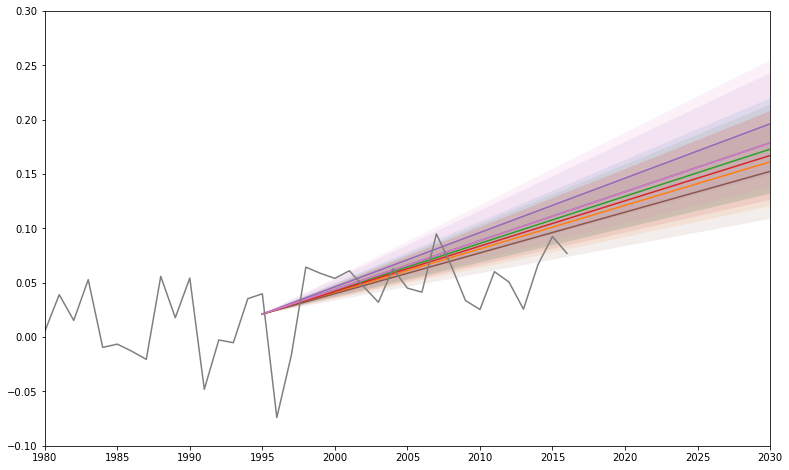

In [66]:
fig, ax = plt.subplots(figsize=(13, 8))
for i, row in scenarios_df.iterrows():
    ax.fill_between(row['dates'], row['correction'](row['min']), row['correction'](row['max']), alpha=0.1)
    ax.plot(row['dates'], row['correction'](row['mean']))
ax.plot(slr_df.index, slr_df['height_m'])    
ax.set_xlim(datetime.datetime(1980, 1, 1), datetime.datetime(2030, 1, 1))
ax.set_ylim(-0.1, 0.3)

(722815.0, 766645.0)

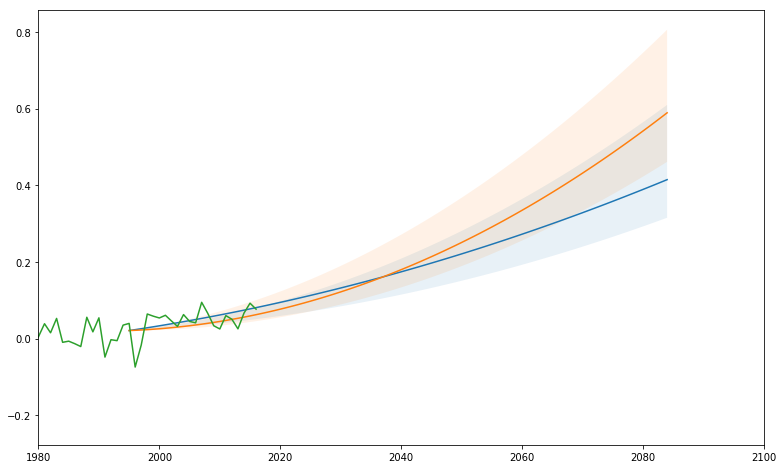

In [73]:
fig, ax = plt.subplots(figsize=(13, 8))
for i, row in scenarios_df[scenarios_df.organization == 'KNMI'].iterrows():
    ax.fill_between(
        row['interp_dates'], 
        row['correction'](row['interp_min']), 
        row['correction'](row['interp_max']), 
        alpha=0.1
    )
    ax.plot(row['interp_dates'], row['correction'](row['interp_mean']))

# for i, row in scenarios_df[scenarios_df.organization == 'KNMI'].iterrows():
#     ax.fill_between(row['dates'], row['correction'](row['min']), row['correction'](row['max']), alpha=0.1)
#     ax.plot(row['dates'], row['correction'](row['mean']))

ax.plot(slr_df.index, slr_df['height_m'])    
ax.set_xlim(datetime.datetime(1980, 1, 1), datetime.datetime(2100, 1, 1))


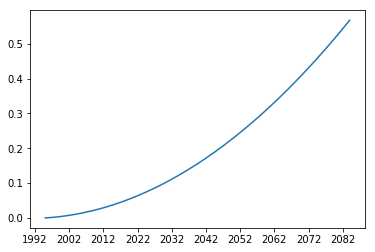

correction                     <function <lambda> at 0x113c276a8>
max                                               [0.0, 0.4, 0.8]
mean                                            [0.0, 0.27, 0.58]
min                                              [0.0, 0.2, 0.45]
name                                                         2014
organization                                                 KNMI
scenario                                                     high
years                                          [1995, 2055, 2085]
dates           [1995-01-01 00:00:00, 2055-01-01 00:00:00, 208...
Name: 6, dtype: object